# Import Library

In [1]:
import os
from pathlib import Path

import pandas as pd
import joblib
import shap

c:\Users\11413929\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def process_training(df):
    df['feat_avg_contribution'] = df['feat_avg_contribution'].fillna(0)

    for col in ['feat_is_blocked_recently', 'feat_is_unblocked_recently', 'feat_is_rename_user_recently']:
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype(int)

    df['feat_count_comment_bad_user'] = df['feat_count_comment_bad_user'].fillna(0)
    df['feat_count_comment_bad_user'] = df['feat_count_comment_bad_user'].astype(int)

    if 'log_timestamp' in df.columns:
        df['log_timestamp'] = pd.to_datetime(df['log_timestamp'])

# Import Files

In [3]:
path = Path(os.getcwd())

project_dir = path.parent

interim_data_dir = project_dir / 'data' / 'interim'
process_data_dir = project_dir / 'data' / 'preprocess'
prediciton_data_dir = project_dir / 'data' / 'prediction'
final_model_dir = project_dir / 'model' / 'final'

In [9]:
# model
p = final_model_dir.glob('*.joblib')
list_file_names = [str(x) for x in p]
latest_model_file = sorted(list_file_names, reverse=True).pop(0)

model = joblib.load(latest_model_file)

In [11]:
# data
id_cols = ['log_id', 'user_id']
target_col = 'is_block_next_period'

df = pd.read_csv(process_data_dir / "test_data.csv").set_index(id_cols)

# predicted values
df_pred = pd.read_csv(prediciton_data_dir / "prediction.csv")

# Preprocess Data

In [12]:
process_training(df)

X = df.filter(regex='^feat', axis=1)
y = df[target_col]

# Analysis

In [13]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer(X)

## SHAP Global Feature Importance

Determine global feature importance based on average of absolute SHAP values

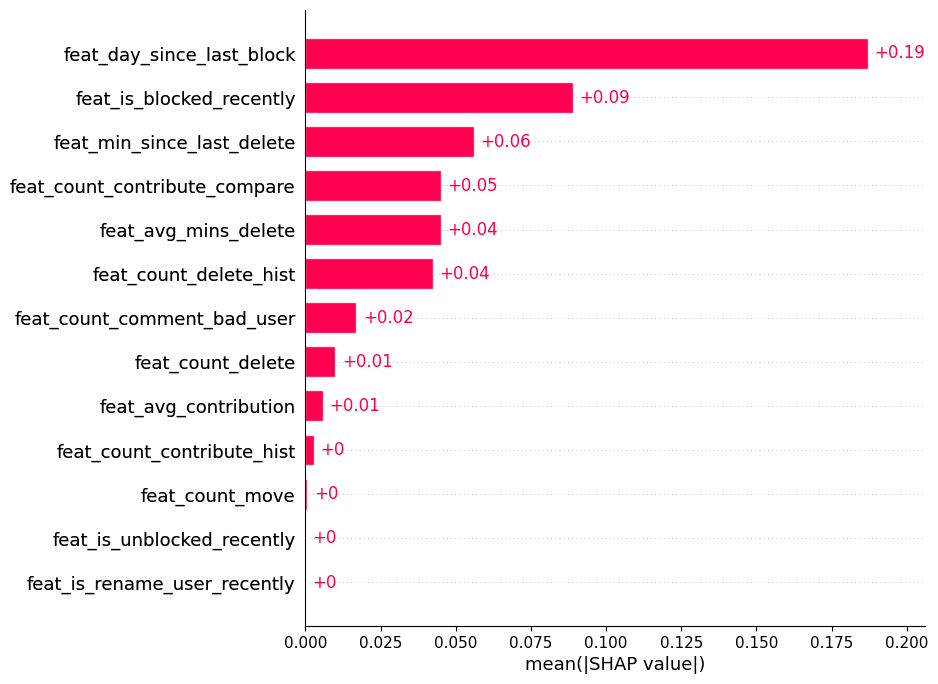

In [40]:
shap.plots.bar(shap_values[:,:,1], max_display=13)

From the graph, we can see that
 - The most importance features which, in average, dominates the most of prediction are the features related to <code>'block'</code> history (number 1-2)
 - The second-most importance features are related to <code>'delete'</code> action in terms of recency and frequency (number 3, 5, 6)
 - Features related to <code>'create'</code> action, however, are less contribute to the prediction than it should be.

## SHAP Summary Plot

Determine the type of impact (postive/negative) on model prediction from feature value (high or low)

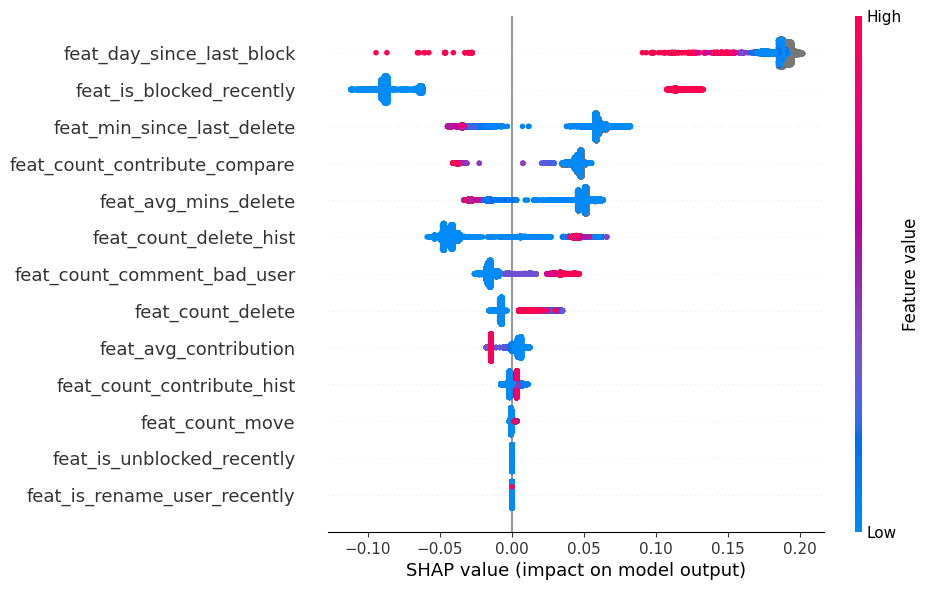

In [39]:
# reference : https://stackoverflow.com/questions/76083485/shap-instances-that-have-more-than-one-dimension
shap.plots.beeswarm(shap_values[:,:,1], max_display=13)

From the graph, we can inspect the prediction behavior as
 - Recent block history (1-2) indicates a higher chance of repeated bad user behaviors in the feature
 - High level of <code>'delete'</code> activity, intepreting from high frequency and low recency, also indicates a future bad user behaviors.
 - Semantic meaning of comments (7) also helps determining bad users as well
 - User with high contribution (<code>'create'</code> action) are less likely to lead to future bad user behaviors.

## Model Prediction with High-Confidence

To determine a scenario where we can fully trust the model, we can focus on the correct prediction on possible bad usages with high confidence (prob > 0.8) and analyze the key attribute of these observations

In [44]:
pred_prob = model.predict_proba(X)
pred_prob = pred_prob[:, 1]

In [77]:
log_id_correct = df_pred.loc[df_pred['is_block_next_period'].eq(df_pred['y_pred']) & (pred_prob > 0.8), 'log_id']
feature_high_confidence = X.loc[X.index.get_level_values(0).isin(log_id_correct)]

In [80]:
feature_high_confidence['feat_day_since_last_block'].value_counts()

feat_day_since_last_block
0.0    804
Name: count, dtype: int64

In [79]:
feature_high_confidence['feat_is_blocked_recently'].value_counts()

feat_is_blocked_recently
1    804
Name: count, dtype: int64

All high-confident prediction are associated with getting blocked from other users (in the same day)

<Axes: >

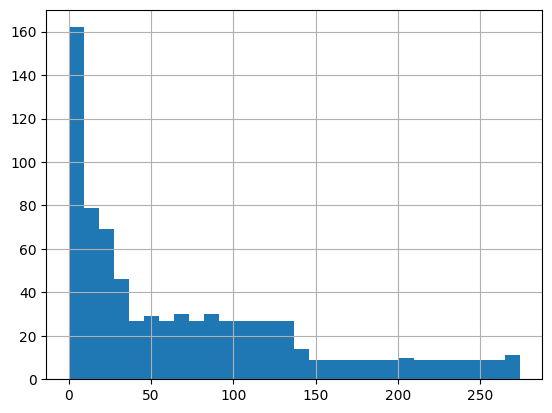

In [126]:
feature_high_confidence['feat_count_delete'].hist(bins=30)

<Axes: >

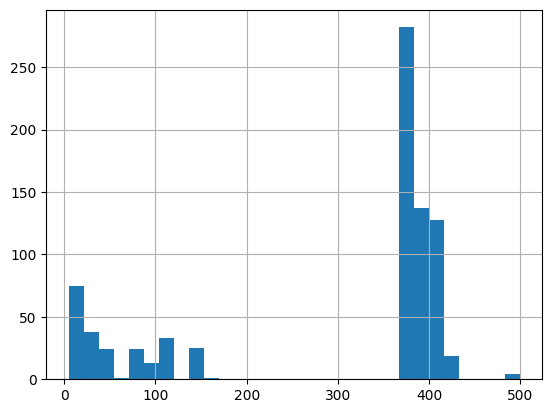

In [87]:
feature_high_confidence['feat_count_delete_hist'].hist(bins=30)

Most of high-confident prediction are related to a high level of <code>'delete'</code> activity : history (graph 2) + recent (graph 1)

In [91]:
feature_high_confidence['feat_avg_contribution'].describe()

count    804.000000
mean       0.577647
std        0.542252
min        0.000000
25%        0.571429
50%        0.571429
75%        0.571429
max        5.428571
Name: feat_avg_contribution, dtype: float64

Most of high-confident prediction are also related to a low contribution (<code>'create'</code> action) to the site

To summarize, we can conclude the scenario of trustful model prediciton as follow:
 - Involved with getting user blocks in the same day
 - High level of 'delete' activities both previously and recently
 - Low average contribution (mostly less than 5 times/day)

## Incorrect Model Prediction (p > 0.8)

In the opposite way from previous, we can also analyze all attributes related to incorrect model prediction

In [118]:
log_id_correct = df_pred.loc[df_pred['is_block_next_period'].eq(0) & df_pred['y_pred'].eq(1) & (pred_prob > 0.8), 'log_id']
feature_low_confidence = X.loc[X.index.get_level_values(0).isin(log_id_correct)]

In [120]:
feature_low_confidence['feat_day_since_last_block'].value_counts()

feat_day_since_last_block
0.0    138
1.0     45
2.0      1
Name: count, dtype: int64

In [121]:
feature_low_confidence['feat_is_blocked_recently'].value_counts()

feat_is_blocked_recently
1    184
Name: count, dtype: int64

We can clearly see that all incorrect predictions (with p > 0.8) are also associated with current user blocks (within previous 2 days)

<Axes: >

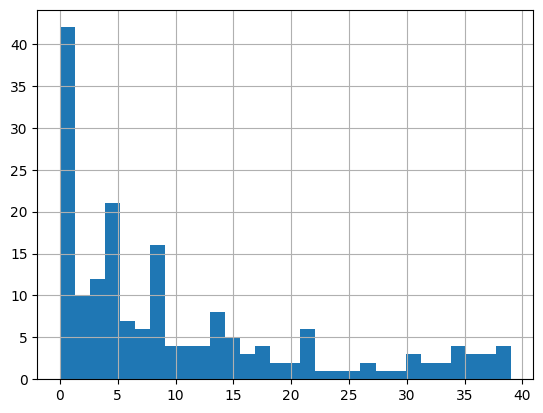

In [128]:
feature_low_confidence['feat_count_delete'].hist(bins=30)

<Axes: >

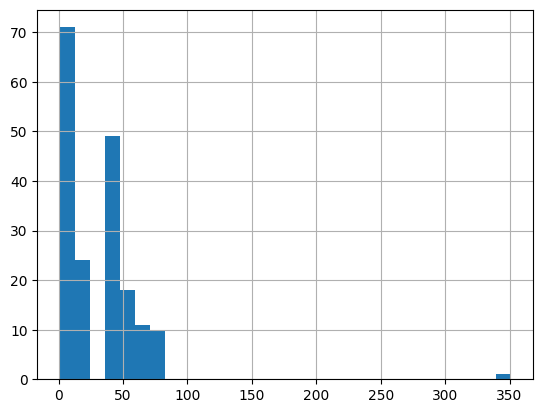

In [123]:
feature_low_confidence['feat_count_delete_hist'].hist(bins=30)

However, incorrect predictions are generally not associated with high level of <code>'delete'</code> activity (as copmpared to the previous analysis)

In [125]:
feature_low_confidence['feat_avg_contribution'].describe()

count    184.000000
mean       3.346273
std        2.558362
min        0.000000
25%        0.571429
50%        5.214286
75%        5.714286
max        5.857143
Name: feat_avg_contribution, dtype: float64

As expected, we can see higher level of user contribution to the site (unlike the previous one)

In summary, the features which mainly contribute to the incorrect prediction are related to user block history that irrelevant to the problem -> improve by not including the recent block history in the model.

# Further Implementation

From the ongoing nalysis and model development, list of ideas for further improvement or additional development can be listed here:
 - Additional information to improve model performance
    - User Profile
    - Data Description
    - Page History
 - Solution Improvement
    - Data pre-processing steps to exclude recent user block history (like considering 'unblock' action)
    - Develop new features on new user actions
    - Text processing on comments, such as, Word Embedding, Word Vectorization, Domain Words detection
    - New Solution : Sequential model tahat take into the account both user comments and user action history, such as LSTH, RNN